In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pdb
import pandas as pd
import pickle

from monai.data import DataLoader, decollate_batch
from monai.utils import set_determinism
from tqdm import tqdm

import torch
from torch.utils.data import Subset

from utils.dataset import BraTSDataset
from utils.model import create_SegResNet, inference
from utils.transforms import contr_syn_transform as data_transform
from utils.plot import *

In [2]:
from utils.logger import Logger
logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
RANDOM_SEED = 0
set_determinism(seed=RANDOM_SEED)

In [4]:
dataset_orig = BraTSDataset(
    version='2017',
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)
loader_orig = DataLoader(dataset_orig, batch_size=1, shuffle=False, num_workers=8)

dataset_synth = BraTSDataset(
    version='2017',
    synth = True,
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['basic']
)
loader_synth = DataLoader(dataset_synth, batch_size=1, shuffle=False, num_workers=8)

logger.debug("Data loaded")
logger.debug(f"Length of dataset: {len(dataset_orig)}, {len(dataset_synth)}")

[DEBUG] Data loaded
[DEBUG] Length of dataset: 97, 97


In [5]:
id_index = 0
index_list = dataset_orig.get_ids()

### Run from here!!

In [52]:
id_ = index_list[id_index]
id_index += 1

Find the slice (height index) at which Tumor Core is most present

In [53]:
label_list = ["TC", "WT", "ET", "Combined"]

label_orig = dataset_orig.get_with_id(id_)['label']
label_centroid =  find_centroid_3d(label_orig[0]) # centroid of TC (Tumor Core)
h_index=label_centroid[-1]


TC: 0.19630%


ID: 317
Original
FLAIR:	-0.000 ± 0.375 [-2.753, 10.702]
T1w:	-0.000 ± 0.375 [-3.811, 3.814]
T1Gd:	0.000 ± 0.375 [-2.935, 13.004]
T2w:	-0.000 ± 0.375 [-1.794, 4.983]


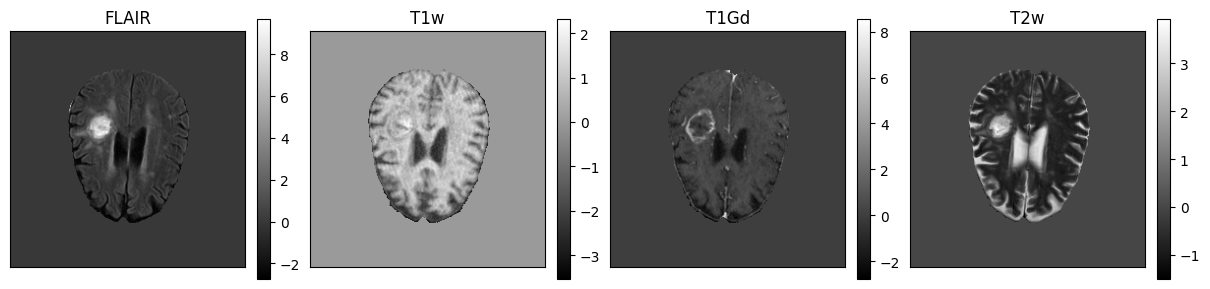

Synthesized
FLAIR:	-0.000 ± 0.375 [-2.753, 10.702]
T1w:	-0.000 ± 0.375 [-3.811, 3.814]
T1Gd**:	0.008 ± 0.261 [-3.076, 7.914]
T2w:	-0.000 ± 0.375 [-1.794, 4.983]


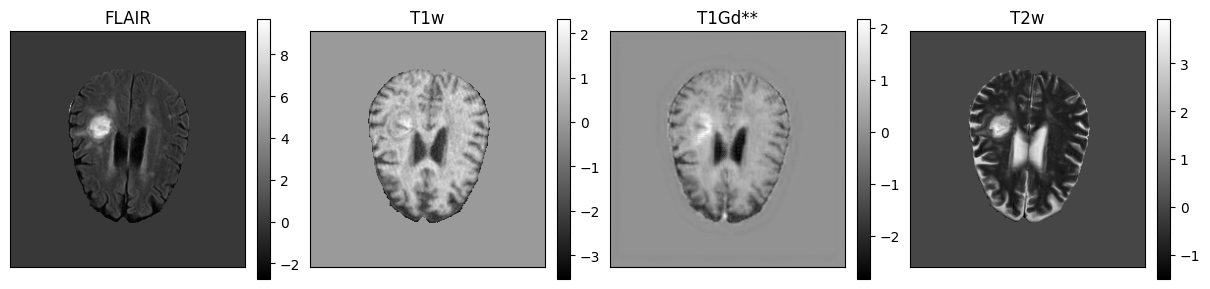

In [54]:
print(f"ID: {id_}")
print("Original")
image_orig = dataset_orig.get_with_id(id_)['image']
brain_plot(image_orig, channels=["FLAIR", "T1w", "T1Gd", "T2w"], h_index=h_index, horiz=True, no_batch=True)

print("Synthesized")
image_synth = dataset_synth.get_with_id(id_)['image']
brain_plot(image_synth, channels=["FLAIR", "T1w", "T1Gd**", "T2w"], h_index=h_index, horiz=True, no_batch=True)

In [55]:
def plot_label(img, h_index=77):
    start_index = 0
    title = "Tumor masks"
    plt.figure(figsize=(12, 8))

    for label_index in range(len(label_list)):
        brain_slice = img[..., h_index].detach().cpu()
        if label_index < 3:
            brain_slice = brain_slice[label_index, ...]
        else:
            brain_slice = brain_slice.sum(axis=0)
        brain_slice = brain_slice.T
        plt.subplot(3, 4, start_index + label_index + 1)
        plt.title(label_list[label_index], fontsize=15)
        if label_index == 0:
            plt.ylabel(title, fontsize=15)
        plt.xticks([])
        plt.yticks([])
        cmap = "gray" if label_index < 3 else "magma"
        plt.imshow(brain_slice, cmap=cmap)

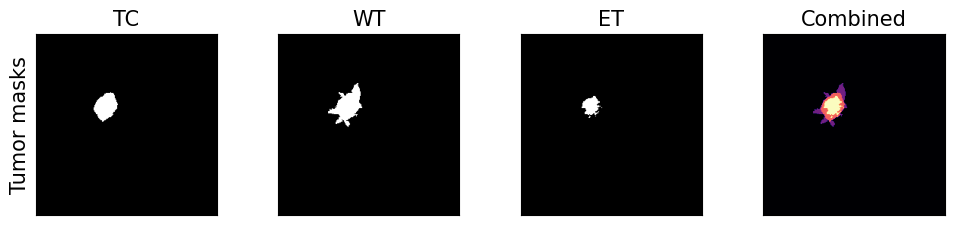

In [ ]:
plot_label(label_orig, h_index=h_index)